# Initialize

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.qasm2 import dumps
from qiskit_aer import AerSimulator, QasmSimulator, Aer
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import RZZGate, RZGate
from qiskit.circuit import Delay
from qiskit.circuit.library import UnitaryGate

import mysql.connector
import networkx as nx
import os
import sys
from copy import deepcopy

from qEmQUIP import QEM, conf
import mysql.connector

import warnings
warnings.filterwarnings(action='ignore')

module_path = os.path.abspath(os.path.join('.', 'wrappers'))
if module_path not in sys.path:
    sys.path.append(module_path)

from commons import (
    used_qubits, sum_middle_digits_dict
)

from wrappers.multiprogramming_wrapper import (
    avoid_simultaneous_cnot, add_zz_on_simultaneous_cnot, 
    build_idle_coupling_map, multiprogram_compilation_qiskit, merge_circuits,
    get_LF_presets_cm
)
from wrappers.polar_wrapper import (
        polar_code_p2, get_logical_error_on_accepted_states
)

from wrappers.prune_wrapper import (
    create_full_graph, generate_figures, generate_node_errors, generate_edge_errors,
    get_latest_calibration_id, get_edges_threshold, get_readout_threshold, get_LF_qubits
)

from wrappers.dd_wrapper import (
    convert_dt_to_us, count_delay_durations, apply_pad_delay, get_delay_information, get_dd_information, 
    get_delay_and_dd_information_us
)

from wrappers.qiskit_wrapper import (
    apply_dd, get_zz_rates_from_backend_in_hz, get_qubits_T1_T2, get_gates_length, generate_errors_thermal_relaxation, 
generate_thermal_noise_model_on_used_qubits, get_neighbor_zz_rates_by_qubit, create_rzz_operator,
replace_delay_with_rzz
)


# MySQL connection parameters
mysql_config = {
    'user': 'handy',
    'password': 'handy',
    'host': 'ec2-16-171-135-24.eu-north-1.compute.amazonaws.com',
    'database': 'calibration_data'
}

# Connect to the MySQL database
conn = mysql.connector.connect(**mysql_config)

shots = 10000
seed_simulator=12345

In [4]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

import matplotlib.pyplot as plt
# plt.style.use('tableau-colorblind10')
# font = {'size'   : 16}
# plt.rc('font', **font)

import numpy as np
import pandas as pd
import seaborn as sns
import re

# CB_color_cycle = ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF',
                 
#                  ]

CB_color_cycle = [
    '#006BA4',  # Blue
    '#FF800E',  # Orange
    '#ABABAB',  # Gray
    '#595959',  # Dark Gray
    '#5F9ED1',  # Light Blue
    '#C85200',  # Dark Orange
    '#898989',  # Medium Gray
    '#A2C8EC',  # Pale Blue
    '#FFBC79',  # Light Orange
    '#CFCFCF',  # Light Gray
    '#009E73',  # Green (Colorblind-friendly)
    '#F0E442'   # Yellow (Colorblind-friendly)
]
                  

#1F77B4 0
#FFBB78 3
#2CA02C 4
#98DF8A 5
#D62728 6
#FF9896 7

CB_color_cycle_polar = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

markers = ['o', 'v', 'd', 's', '+', 'x', '^', '*', '<', '>', 'p', '1', '2', '3', '4']
linestyles = ['-', '--', ':', '-.', '-', '--', '-.', ':']

#calibration_sets = ["real", "avg", "recent", "decay_r"]
calibration_sets = ["real", "avg"]
# opts = ["TriQ", "SCR"]
# opts = ["TriQ"]




In [5]:
# # handykur@ucm.es
token = "476ea8c61cc54f36e4a21d70a8442f94203c9d87096eaad0886a3e8154d8c2e79bcad6f927c6050a76335dd68d783f478c1b828504748a4377b441c335c831aa"

hw_name = "ibm_sherbrooke"
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.backend(hw_name)

In [6]:
sim_ideal = AerSimulator()
sim_noisy = AerSimulator.from_backend(backend)
noise_model_backend = NoiseModel.from_backend(backend)

In [7]:
pm = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

## Circuit

In [8]:
# AND5
qasm_str = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
x q[0];
x q[1];
x q[2];
x q[3];
u3(0,0,-pi/4) q[3];
u3(pi/2,0,pi) q[4];
cx q[3],q[4];
u3(0,0,pi/4) q[4];
cx q[3],q[4];
u3(0,0,-pi/4) q[4];
u3(pi/2,0,pi) q[4];
u3(pi/2,0,pi) q[4];
u3(pi/2,0,pi) q[3];
u3(0,0,pi/4) q[3];
cx q[2],q[3];
u3(0,0,-pi/4) q[3];
u3(pi/2,0,pi) q[3];
cx q[0],q[3];
u3(0,0,pi/4) q[3];
cx q[1],q[3];
u3(0,0,-pi/4) q[3];
cx q[0],q[3];
u3(0,0,pi/4) q[3];
cx q[1],q[3];
u3(0,0,-pi/4) q[3];
u3(pi/2,0,pi) q[3];
u3(0,0,pi/4) q[3];
cx q[2],q[3];
u3(0,0,-pi/4) q[3];
u3(pi/2,0,pi) q[3];
u3(0,0,pi/4) q[3];
cx q[3],q[4];
u3(0,0,-pi/4) q[4];
cx q[3],q[4];
u3(0,0,pi/4) q[4];
u3(pi/2,0,pi) q[4];
u2(0,pi) q[4];
u3(pi/2,-2*pi,pi) q[3];
u3(0,0,pi/4) q[3];
cx q[2],q[3];
u3(0,0,-pi/4) q[3];
u3(pi/2,-2*pi,pi) q[3];
u3(0,0,pi/4) q[3];
cx q[1],q[3];
u3(0,0,-pi/4) q[3];
cx q[0],q[3];
u3(0,0,pi/4) q[3];
cx q[1],q[3];
u3(0,0,-pi/4) q[3];
cx q[0],q[3];
u1(-pi/16) q[0];
cx q[0],q[4];
u1(pi/16) q[4];
cx q[0],q[4];
u1(-pi/16) q[4];
u2(0,pi) q[4];
u2(0,pi) q[4];
cx q[0],q[1];
u1(pi/16) q[1];
cx q[1],q[4];
u1(-pi/16) q[4];
cx q[1],q[4];
u1(pi/16) q[4];
u2(0,pi) q[4];
u2(0,pi) q[4];
cx q[0],q[1];
u1(-pi/16) q[1];
cx q[1],q[4];
u1(pi/16) q[4];
cx q[1],q[4];
u1(-pi/16) q[4];
u2(0,pi) q[4];
u2(0,pi) q[4];
u3(pi/2,-2*pi,pi) q[3];
u3(0,0,pi/4) q[3];
cx q[2],q[3];
cx q[1],q[2];
u1(pi/16) q[2];
cx q[2],q[4];
u1(-pi/16) q[4];
cx q[2],q[4];
u1(pi/16) q[4];
u2(0,pi) q[4];
u2(0,pi) q[4];
cx q[0],q[2];
u1(-pi/16) q[2];
cx q[2],q[4];
u1(pi/16) q[4];
cx q[2],q[4];
u1(-pi/16) q[4];
u2(0,pi) q[4];
u2(0,pi) q[4];
cx q[1],q[2];
u1(pi/16) q[2];
cx q[2],q[4];
u1(-pi/16) q[4];
cx q[2],q[4];
u1(pi/16) q[4];
u2(0,pi) q[4];
u2(0,pi) q[4];
cx q[0],q[2];
u1(-pi/16) q[2];
cx q[2],q[4];
u1(pi/16) q[4];
cx q[2],q[4];
u1(-pi/16) q[4];
u2(0,pi) q[4];
u3(0,0,-pi/4) q[3];
u3(pi/2,-2*pi,pi) q[3];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
"""

qc = QuantumCircuit.from_qasm_str(qasm_str)

In [9]:
tqc = pm.run(qc)

# Noise Model

In [10]:
#dir(noise_model_backend)

In [11]:
noise_dict = noise_model_backend.to_dict()

In [12]:
noise_dict["errors"][129]["gate_qubits"]

[(3, 2)]

In [13]:
noise_dict["errors"][129]["instructions"][2]

[{'name': 'pauli', 'qubits': [0, 1], 'params': ['II']},
 {'name': 'reset', 'qubits': [0]},
 {'name': 'id', 'qubits': [1]}]

In [14]:
print(len(noise_dict["errors"][129]["probabilities"]), 1 - noise_dict["errors"][129]["probabilities"][0])

144 0.007235894029981038


# Backend Property

In [15]:
backend.name

'ibm_sherbrooke'

In [16]:
dt = backend.dt
dt

2.2222222222222221e-10

### ZZ Rate

In [17]:
zz_rates = get_zz_rates_from_backend_in_hz(backend)

## Thermal


In [18]:
gates_length = get_gates_length(tqc, backend)
gates_length

{'rz': 0,
 'sx': 56.888888888888886,
 'ecr': 533.3333333333333,
 'x': 56.888888888888886,
 'measure': 1216}

In [19]:
errors_thermal = generate_errors_thermal_relaxation(tqc, backend)

In [20]:
noise_thermal = generate_thermal_noise_model_on_used_qubits(tqc, backend)
sim_noisy_thermal = AerSimulator(configuration=backend.configuration(), noise_model=noise_thermal)

In [21]:
# This model doesn't make sense
#noise_thermal_delay = NoiseModel()
#noise_thermal_delay = deepcopy(noise_model_backend)

#used_qbs = used_qubits(tqc)

#for q in used_qbs:
#    noise_thermal_delay.add_quantum_error(errors_thermal["delay"][q], "delay", [q])

#sim_noisy_delay = AerSimulator(configuration=backend.configuration(), noise_model=noise_thermal_delay)

In [22]:
#dir(noise_thermal_delay)

# Simulate

Running on the noiseless simulation, we will get the real correct answer

In [24]:
# for result running with ideal simulator (no noise)
result_ideal = sim_ideal.run(tqc, shots=10000, seed_simulator=12345).result().get_counts()
correct_answer = list(result_ideal.keys())[0]
correct_answer

'11111'

In [25]:
shots = 10000
seed_simulator = 12345

In [26]:
def simulate_circuit_with_noisy_simulator(tqc, sim, seed_simulator, correct_answer):
    result_noisy = sim.run(tqc, shots=shots, seed_simulator=seed_simulator).result().get_counts()
    return result_noisy[correct_answer]


In [27]:
# for result running with noisy simulator from backend
result_noisy = simulate_circuit_with_noisy_simulator(tqc, sim_noisy, seed_simulator, correct_answer)

# for result running with thermal error from backend properties
result_thermal = simulate_circuit_with_noisy_simulator(tqc, sim_noisy_thermal, seed_simulator, correct_answer)

print(result_noisy, result_thermal)

6634 7512


### Analyze Delay

This `get_delay_and_dd_information_us` function will analyze the circuit based on the given backend, and return
circuits: with pad delay, and dd delay, and the delays timing.

Index 0 is for the pad delay, while index 1 is for the pad dd

In [28]:
list_circuit, list_delays = get_delay_and_dd_information_us(tqc, backend, "XpXm")

In [29]:
# add delay operation to the circuits
tqc_delay = list_circuit[0]
tqc_dd = list_circuit[1]

In [30]:
print(list_delays)

({55: 24.462, 67: 20.921, 68: 3.385, 69: 18.084, 70: 28.117}, {55: 23.438, 67: 19.783, 68: 3.157, 69: 17.287, 70: 27.662})


In [31]:
# for result running with noisy simulator from backend
result_noisy_wd = simulate_circuit_with_noisy_simulator(tqc_delay, sim_noisy, seed_simulator, correct_answer)

# for result running with thermal error from backend properties
result_noisy_dd = simulate_circuit_with_noisy_simulator(tqc_dd, sim_noisy, seed_simulator, correct_answer)

print(result_noisy_wd, result_noisy_dd)

5266 5054


From the result above we can conclude that:
- Adding delay will reduce the fidelity
- Adding DD without the correct noise model (coherent error with zz rotation) will also reduce the fidelity

In [32]:
# for result running with noisy simulator from backend
result_thermal_wd = simulate_circuit_with_noisy_simulator(tqc_delay, sim_noisy_thermal, seed_simulator, correct_answer)

# for result running with thermal error from backend properties
result_thermal_dd = simulate_circuit_with_noisy_simulator(tqc_dd, sim_noisy_thermal, seed_simulator, correct_answer)

print(result_thermal_wd, result_thermal_dd)

7512 7438


## Analyze Simultaneous CNOT 

In [33]:
tqc_zz = add_zz_on_simultaneous_cnot(tqc, backend)
tqc_zz = transpile(tqc_zz, optimization_level=0, backend=backend) # transpile to basis gate

In [34]:
print(tqc_zz.count_ops())
print(tqc.count_ops())

OrderedDict({'rz': 217, 'sx': 128, 'ecr': 58, 'x': 14, 'measure': 5})
OrderedDict({'rz': 190, 'sx': 118, 'ecr': 56, 'x': 12, 'measure': 5})


In [35]:
result_noisy_zz = simulate_circuit_with_noisy_simulator(tqc_zz, sim_noisy, seed_simulator, correct_answer)
result_noisy_zz

6046

## Analyze adding rzz to delay operation

In [36]:
from qiskit.circuit import Qubit, QuantumRegister, Instruction, Parameter
import qiskit.quantum_info as qi
import numpy as np


In [37]:
tqc_rzz = replace_delay_with_rzz(tqc, backend, False, 1.5)

In [38]:
print(tqc_rzz.count_ops())
print(tqc.count_ops())

OrderedDict({'rz': 190, 'sx': 118, 'unitary': 64, 'ecr': 56, 'x': 12, 'measure': 5})
OrderedDict({'rz': 190, 'sx': 118, 'ecr': 56, 'x': 12, 'measure': 5})


In [39]:
#tqc_rzz.draw("mpl", idle_wires=False)

In [40]:
# This code is to add instruction to the simulator
#from qiskit.transpiler import Target, InstructionProperties
#rzz_prop = {}

#edges = backend.coupling_map.get_edges()

#for e in edges:
#    rzz_prop[e] = InstructionProperties(duration=0, error=0)

#sim_noisy_rzz = deepcopy(sim_noisy)
#sim_noisy_rzz.target.add_instruction(Instruction("unitary", 2, 0, []), rzz_prop)

#list_name = []
#for i in sim_noisy_rzz.instructions:
#    list_name.append(i[0].name)
    #if i[0].name == "unitary":
    #    print(i)
    
#list_name_unique = list(set(list_name))
#list_name_unique

In [41]:
# run with backend noisy simulator (wd = with delay)
result_noisy_rzz = sim_noisy.run(tqc_rzz, shots=shots, seed_simulator=seed_simulator).result().get_counts()
result_noisy_rzz[correct_answer]

972

In [42]:
# for result running with thermal error from backend properties
result_thermal_rzz = sim_noisy_thermal.run(tqc_rzz, shots=shots, seed_simulator=seed_simulator).result().get_counts()
result_thermal_rzz[correct_answer]

1060

### Apply dd to reduce delay

In [43]:
from qiskit.circuit.library import XGate, YGate, ZGate, RZGate
from qiskit.transpiler.passes import ALAPScheduleAnalysis, ASAPScheduleAnalysis, PadDynamicalDecoupling

In [44]:
tqc_dd = apply_dd(tqc, backend, "XX", "alap")
#tqc_rzz_dd = apply_dd(tqc_rzz, sim_noisy_rzz, "XX", "alap") # this one doesn't work as it multiplies the delay
#tqc_dd.draw("mpl", idle_wires=False)

In [45]:
print(count_delay_durations(tqc_dd))
#print(count_delay_durations(tqc_rzz))
#print(count_delay_durations(tqc_rzz_dd))
print(count_delay_durations(tqc_delay))

{55: 105472, 67: 89024, 68: 14208, 69: 77792, 70: 124480}
{55: 110080, 67: 94144, 68: 15232, 69: 81376, 70: 126528}


In [47]:
# run with backend noisy simulator (wd = with delay)
result_noisy_dd = sim_noisy.run(tqc_dd, shots=shots, seed_simulator=seed_simulator).result().get_counts()
result_noisy_dd[correct_answer]

5054

In [48]:
tqc_dd_rzz = replace_delay_with_rzz(tqc_dd, backend)

In [49]:
print(tqc.count_ops())
print(tqc_rzz.count_ops())
print(tqc_dd.count_ops())
print(tqc_dd_rzz.count_ops())

OrderedDict({'rz': 190, 'sx': 118, 'ecr': 56, 'x': 12, 'measure': 5})
OrderedDict({'rz': 190, 'sx': 118, 'unitary': 64, 'ecr': 56, 'x': 12, 'measure': 5})
OrderedDict({'delay': 235, 'rz': 190, 'sx': 118, 'x': 76, 'ecr': 56, 'measure': 5})
OrderedDict({'rz': 190, 'unitary': 138, 'sx': 118, 'x': 76, 'ecr': 56, 'measure': 5})


In [50]:
# run with backend noisy simulator (wd = with delay)
#tmp_circ = transpile(tqc_dd_rzz, optimization_level=0, backend=backend) # transpile to basis gate
result_noisy_dd_rzz = sim_noisy.run(tqc_dd_rzz, shots=10000, seed_simulator=seed_simulator).result().get_counts()
result_noisy_dd_rzz[correct_answer]

6450

In [51]:
backend.configuration().timing_constraints

{'acquire_alignment': 16,
 'granularity': 16,
 'min_length': 64,
 'pulse_alignment': 16}

In [52]:
basis_gates = deepcopy(backend.configuration().basis_gates)
basis_gates.append("rzz")
basis_gates

['ecr', 'id', 'rz', 'sx', 'x', 'rzz']

In [53]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import ALAPSchedule, Optimize1qGatesDecomposition

pm_1q_opt = PassManager(
        #Optimize1qGatesDecomposition(backend.configuration().basis_gates)
        Optimize1qGatesDecomposition(basis_gates)
    )

# Combine Everything

In [56]:
# prepare the circuit
token = "476ea8c61cc54f36e4a21d70a8442f94203c9d87096eaad0886a3e8154d8c2e79bcad6f927c6050a76335dd68d783f478c1b828504748a4377b441c335c831aa"
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token, skip_db=True)

qasm_files = q.get_qasm_files_from_path("./circuits/calibration/")
print(qasm_files)

pm = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

Connecting to quantum service...
Saving IBM Account...
Retrieving the real backend information of ibm_kyiv...
./circuits/calibration/
['./circuits/calibration/OR_5.qasm', './circuits/calibration/hs4.qasm', './circuits/calibration/AND_5.qasm', './circuits/calibration/bv4.qasm', './circuits/calibration/adder_n4.qasm', './circuits/calibration/fredkin.qasm', './circuits/calibration/toffoli_n3.qasm']


In [57]:
pqc = q.get_circuit_properties(qasm_source=qasm_files[0])
pqc.circuit.draw("mpl", idle_wires=False, fold=-1)
qc = pqc.circuit

In [58]:
from random import randint

In [59]:
def simulate_circuit_idle_noise(qc, backend, shots):
    sim_ideal = AerSimulator()
    sim_noisy = AerSimulator.from_backend(backend)

    seed_simulator = randint(1, 9999999)
    
    # for result running with ideal simulator (no noise)
    result_ideal = sim_ideal.run(qc, shots=shots, seed_simulator=seed_simulator).result().get_counts()
    correct_answer = list(result_ideal.keys())[0]
    
    tqc = pm.run(qc)
    tqc_rzz = replace_delay_with_rzz(tqc, backend, False)

    result_noisy = sim_noisy.run(tqc, shots=shots, seed_simulator=seed_simulator).result().get_counts()
    
    result_noisy_rzz = sim_noisy.run(tqc_rzz, shots=shots, seed_simulator=seed_simulator).result().get_counts()
    #print("Normal:", result_noisy[correct_answer])
    
    tqc_dd = apply_dd(tqc, backend, "XX", "alap")
    tqc_dd_rzz = replace_delay_with_rzz(tqc_dd, backend)
    
    result_noisy_dd = sim_noisy.run(tqc_dd_rzz, shots=shots, seed_simulator=seed_simulator).result().get_counts()
    #print("with DD:", result_noisy_dd[correct_answer])

    return result_noisy[correct_answer]/shots, result_noisy_rzz[correct_answer]/shots, result_noisy_dd[correct_answer]/shots

In [60]:
simulate_circuit_idle_noise(qc, backend, 10000)

(0.6693, 0.2623, 0.6532)

In [68]:
list_circuit_name = []
list_backend = []
list_compilation = []
list_result = []

shots = 10000

for idx in range(2):
    for qasm_str in qasm_files:
        pqc = q.get_circuit_properties(qasm_source=qasm_str)
        qc = pqc.circuit
    
        result = simulate_circuit_idle_noise(qc, backend, shots)
    
        #print(f"{pqc.name} => Without DD:{result[0]}, with DD: {result[1]} ")
    
        list_circuit_name.append(pqc.name)
        list_backend.append(backend.name)
        list_compilation.append("Q-3")
        list_result.append(result[0])

        list_circuit_name.append(pqc.name)
        list_backend.append(backend.name)
        list_compilation.append("Q-3-rzz")
        list_result.append(result[1])
        
        list_circuit_name.append(pqc.name)
        list_backend.append(backend.name)
        list_compilation.append("Q-3-XpXm")
        list_result.append(result[2])

In [69]:
import pandas as pd
df = pd.DataFrame({
    'circuit_name': list_circuit_name,
    'hw_name': list_backend,
    'compilation_name': list_compilation,
    'tvd': list_result,
    })

In [81]:
def show_summary_bar_lines(df, opts, legends, circuits, ylim, ylabel, figsize=(12,5), 
                           width = 0.08, show_legend = True, legend_position = None, color_idx_add = 0,
                          file_name="", xlabel = None):
    fig, ax = plt.subplots(figsize=figsize)
    width = width
    x = np.arange(len(circuits))
    
    for i, opt in enumerate(opts):
        if i == 0:
            color_idx_add = 0
        else:
            color_idx_add = 0
            
        opt_data = df[df['compilation_name'] == opt]
        # print(opt)
        # print(opt_data)
        # print(CB_color_cycle[i + color_idx_add], i + color_idx_add)
        rects = ax.bar(x + i * width, opt_data['mean'], yerr=opt_data['std'], 
                       color=CB_color_cycle[i + color_idx_add], 
                       label=opt, width=width, capsize=2)
    
    ax.set_ylabel(ylabel)
    # ax.set_title('Mean Success rate with STD by Circuit and Opt')
    ax.set_xticks(x + width * (len(opts) - 1) / 2)
    ax.set_xticklabels(circuits)
    ax.grid(axis='y')
    if show_legend:
        if legend_position == None:
            ax.legend(legends, bbox_to_anchor=(1.01, 1))
        else:
            ax.legend(legends, loc = legend_position)
    else:
        ax.legend([])
    # ax.legend()

    if xlabel:
        plt.xlabel(xlabel)
        
    plt.ylim(ylim)
    plt.tight_layout()
    plt.savefig("./output/{}.png".format(file_name), dpi=700)
    plt.show()

In [82]:
df.head()

,circuit_name,hw_name,compilation_name,tvd
0,OR_5,ibm_sherbrooke,Q-3,0.6771
1,OR_5,ibm_sherbrooke,Q-3-rzz,0.3162
2,OR_5,ibm_sherbrooke,Q-3-XpXm,0.6583
3,hs4,ibm_sherbrooke,Q-3,0.9523
4,hs4,ibm_sherbrooke,Q-3-rzz,0.9523


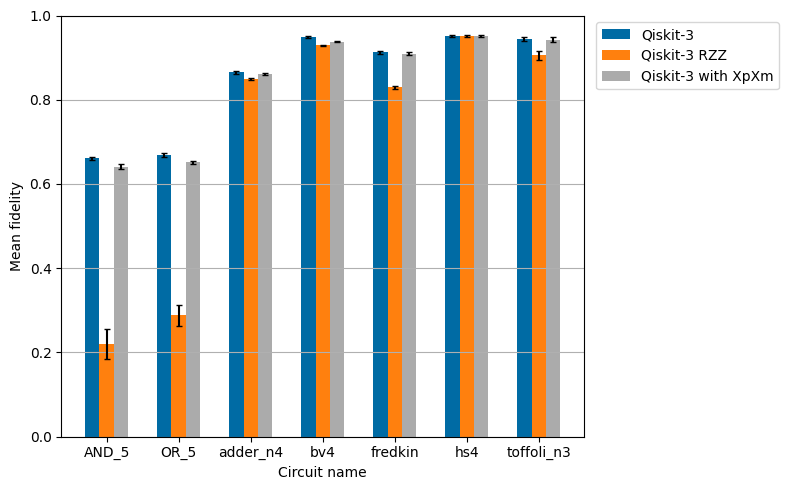

In [83]:
df_summary = df.groupby(['circuit_name', 'compilation_name'])['tvd'].agg(['mean', 'std']).reset_index()

circuits = df_summary['circuit_name'].unique()

opts = ['Q-3', 'Q-3-rzz', 'Q-3-XpXm'
       ]
legends = ["Qiskit-3", "Qiskit-3 RZZ", "Qiskit-3 with XpXm"
          ]

show_summary_bar_lines(df_summary, opts, legends, circuits, [0,1], "Mean fidelity", (8,5), 
                       width=0.2, file_name="simulate_idle_error", xlabel="Circuit name")